## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geore' #dataset-compression
TRANSFORM = 'stft-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_stft_1e5geore_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geore\\stft\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


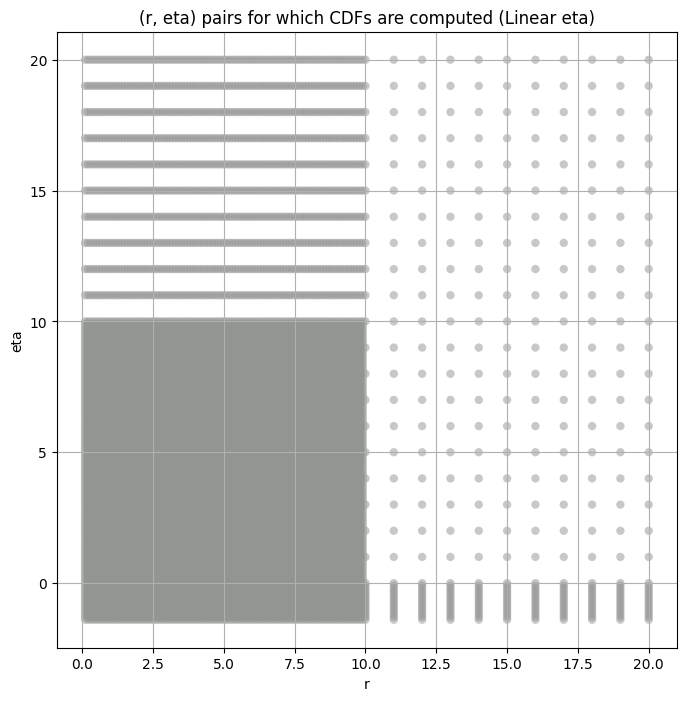

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     45.369470  37.192898  62.504337  105.943756   18.967024   423.49338   
3     28.487642  22.820335  40.596302  133.395070   25.079493   504.80347   
4     28.396730  23.002432  38.076363   95.742080   29.754055   357.59332   
5     17.751116  14.454866  22.739864   76.118126   32.262527   242.55627   
6     15.278565  12.067231  23.165314  177.711350   33.287712   678.38280   
7      6.052383   4.765122   8.304162  116.038055   37.999065   402.60687   
8      1.449654   1.027157   3.279829  950.878000   35.372276  2264.17430   
9      0.369909   0.285179   0.544106  163.989880   45.023357   583.67910   

      total_samples  
band                 
2          100000.0  
3          100000.0  
4          100000.0  
5          100000.0  
6          100000.0  
7          100000.0  
8          100000.0  
9          100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                             
2     45.369470      45.369469       39.263081       37.196613   
3     28.487642      28.487642       24.175890       22.656187   
4     28.396730      28.396730       24.804958       23.272522   
5     17.751116      17.751116       15.613714       14.613070   
6     15.278565      15.278565       13.048805       12.210901   
7      6.052383       6.052382        5.164967        4.786360   
8      1.449654       1.449654        1.111922        1.034404   
9      0.369909       0.369909        0.311541        0.286729   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2          35.703861        34.494583        32.572918        31.044081   
3          21.558861        20.677736        19.297802        18.219467   
4          22.094799        21.116188        19.522474        18.237379   
5          13.845737        13.207838        12.169240        11.331561   
6          11.563072        11.021909        10.138088         9.420738   
7           4.502482         4.270627         3.897818         3.601575   
8           0.976070         0.928206         0.851089         0.789389   
9           0.267708         0.252029         0.226847         0.206930   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2           29.759005        28.648903        27.666063        25.236103  
3           17.329727        16.571680        15.910836        14.317342  
4           17.154909        16.218294        15.393815        13.386931  
5           10.624830        10.012577         9.472379         8.154770  
6            8.813715         8.287159         7.821878         6.687169  
7            3.355725         3.145438         2.961657         2.520097  
8            0.737781         0.693301         0.654302         0.559931  
9            0.190492         0.176539         0.164465         0.135996

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.004475094324188911 45.36947


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.00598635180679763 39.26308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0038314494434549817 37.196613


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.005541703860025005 35.70386


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.00525539316584589 34.494583


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0063072835196993915 32.572918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.007791410319073155 31.04408


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.005905736238781434 29.759005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.00595730424059724 28.648903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.005984103399012189 27.666063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007963828741606404 25.236103
Number of samples: 100000, Without approximation : 100000.0


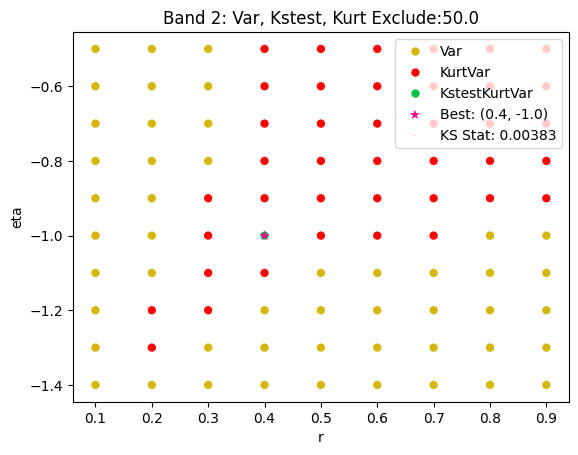

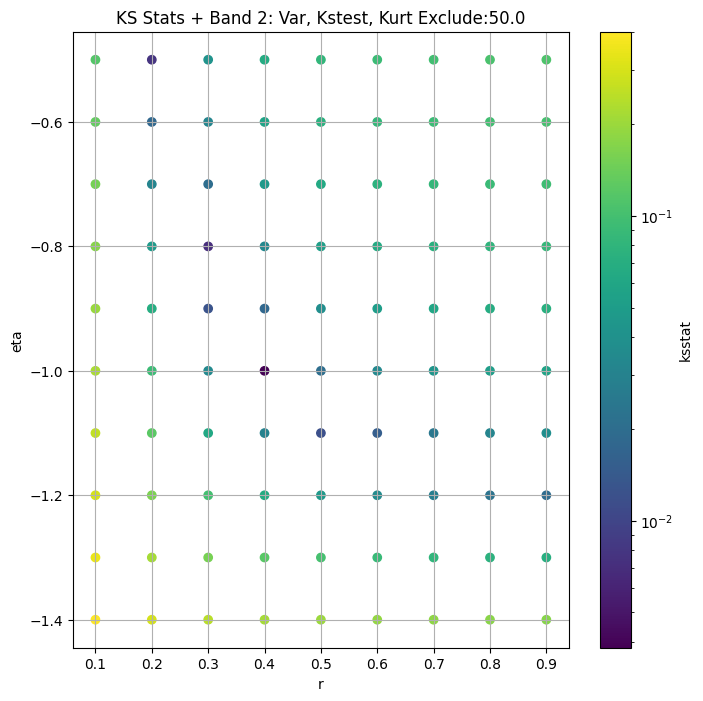

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.005004926490912998 28.487642


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.009470669770586748 24.17589


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.008339335534539694 22.656187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.006719378680801413 21.55886


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.00546483897947192 20.677736


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.004601357202474843 19.297802


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.005152064380432253 18.219467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.00520309594984901 17.329727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.006438653285620433 16.57168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.006267500849408636 15.910836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008065141125935524 14.317342
Number of samples: 100000, Without approximation : 100000.0


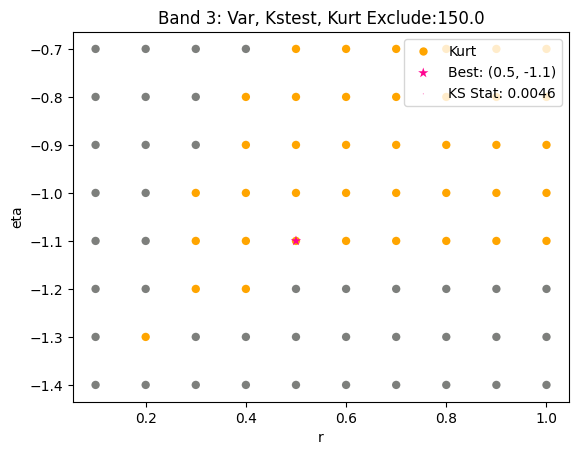

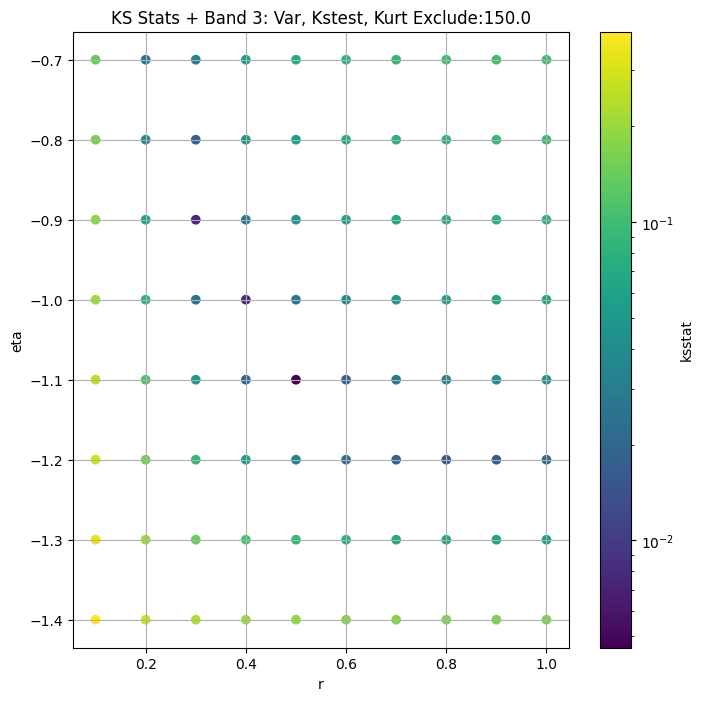

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0067164966758033184 28.39673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.009977750702272803 24.804958


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.006818624196422651 23.272522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.004490089124483412 22.094799


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.005180205857624218 21.116188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.006559827213621645 19.522474


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.008056961861836798 18.23738


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.01094910831222709 17.15491


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.012128183840524609 16.218294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.01010834899294566 15.393815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.011850312169486732 13.386931
Number of samples: 100000, Without approximation : 100000.0


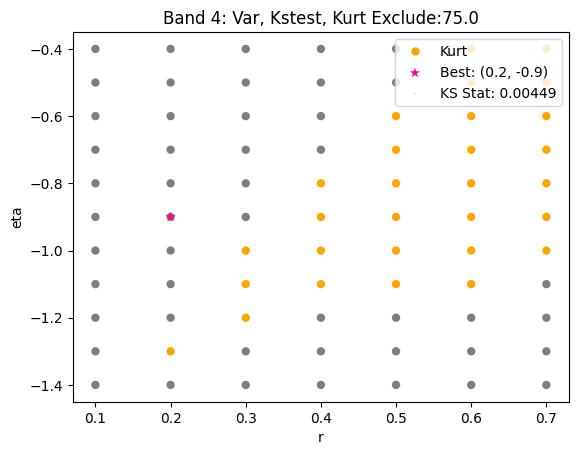

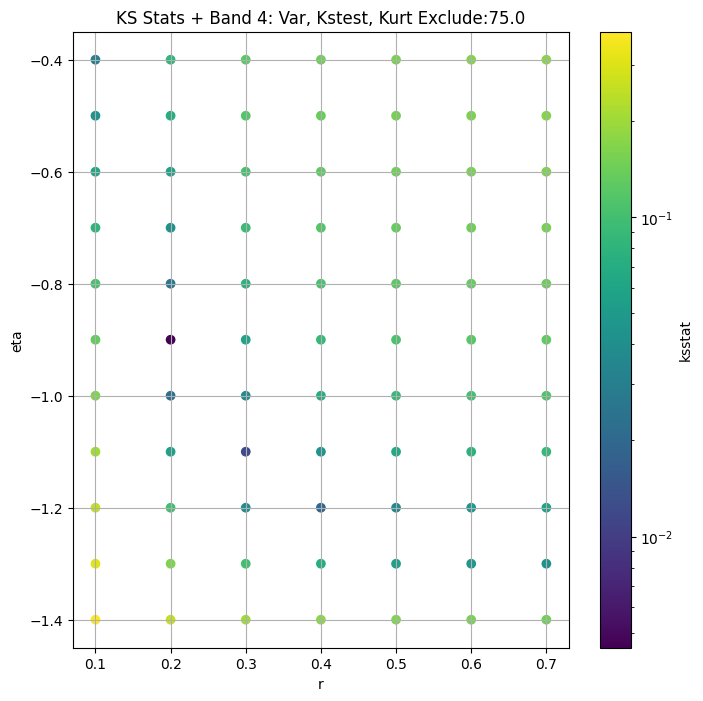

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.00747316295309175 17.751116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.007483482251125453 15.613714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.008600254122194163 14.61307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.00811693271153158 13.8457365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.008896667071446224 13.207838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.010314363439909609 12.16924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.010327082429632713 11.331561


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.01145712637463089 10.62483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.009286582703837885 10.012577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.010146994774895609 9.472379


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.012694237417563741 8.15477
Number of samples: 100000, Without approximation : 100000.0


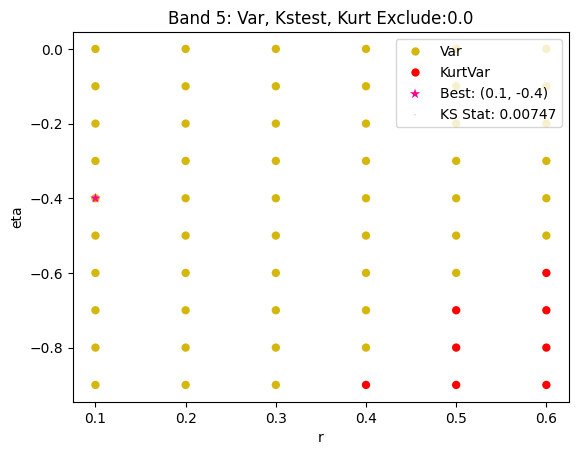

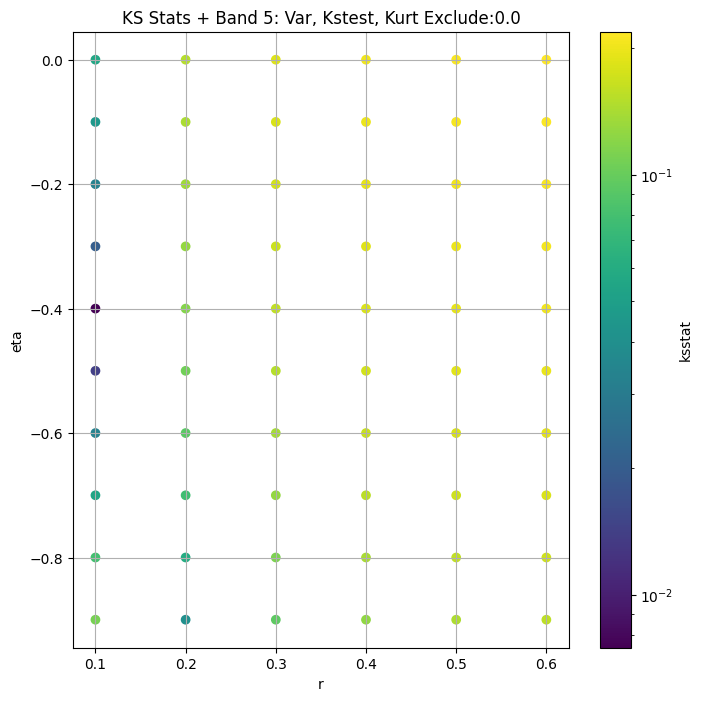

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.013626791444313557 15.278565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.008773330135213087 13.048805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.0078065750011764405 12.210901


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.009371568594960134 11.563072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.0101989410793909 11.021909


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.009412831920562272 10.138088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.01048654852760953 9.420738


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.010556462388250042 8.813715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.011468033655990032 8.287159


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.011570445624006841 7.821878


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.011972400024248948 6.6871686
Number of samples: 100000, Without approximation : 100000.0


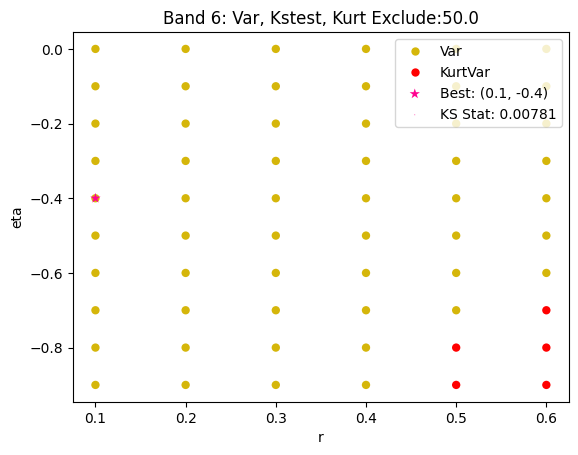

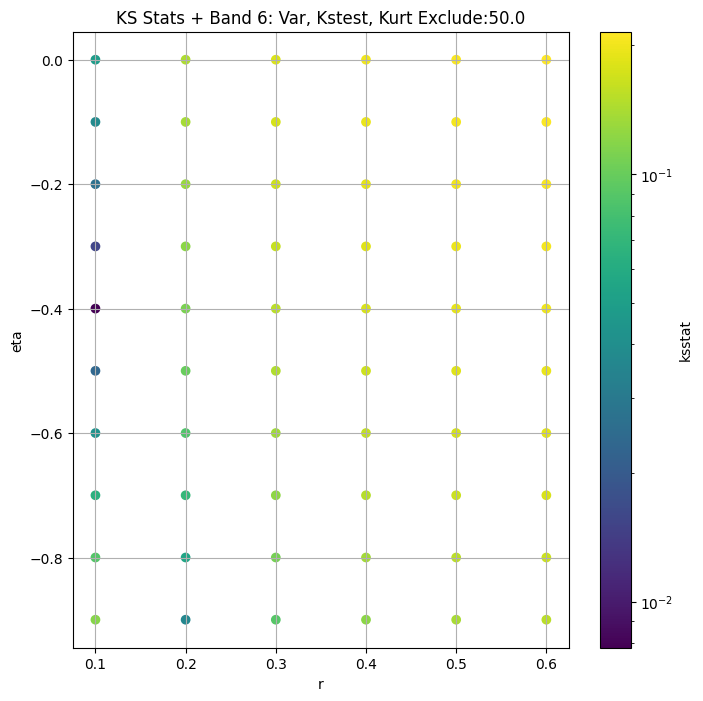

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.013300238541560483 6.0523825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.012282787687796504 5.1649666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.011270017472350125 4.7863603


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.00812287463646133 4.5024824


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.007551291185836799 4.2706265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.009663398703802062 3.8978179


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.009155526358008082 3.6015751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.010223617894116396 3.3557248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.010410557617572619 3.1454382


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.011336399599401206 2.9616573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.011770047882992851 2.5200975
Number of samples: 100000, Without approximation : 100000.0


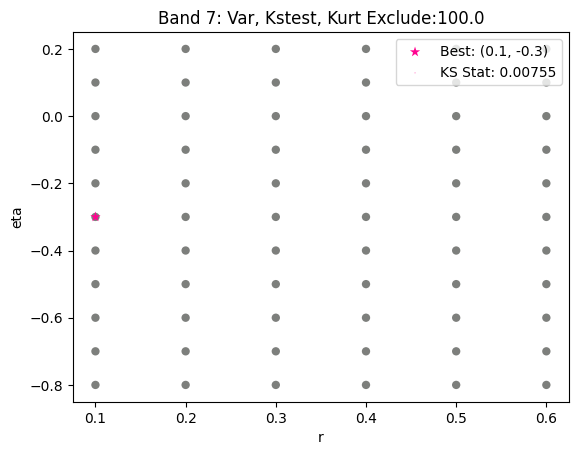

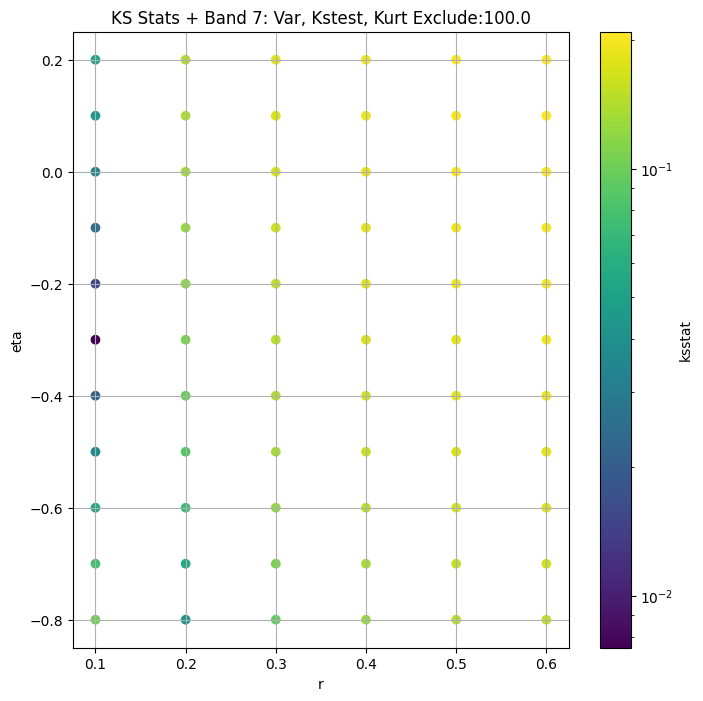

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.018918740243173637 1.4496542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.014025158200881793 1.1119223


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.010153770184070043 1.0344043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.009644809282944422 0.9760696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.011491241110197503 0.92820626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.007753019612679823 0.8510889


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008462954311407696 0.7893889


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.008840356353924252 0.7377807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009762298928336074 0.6933014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010089516013129577 0.6543019


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.012035272291244327 0.55993074
Number of samples: 100000, Without approximation : 100000.0


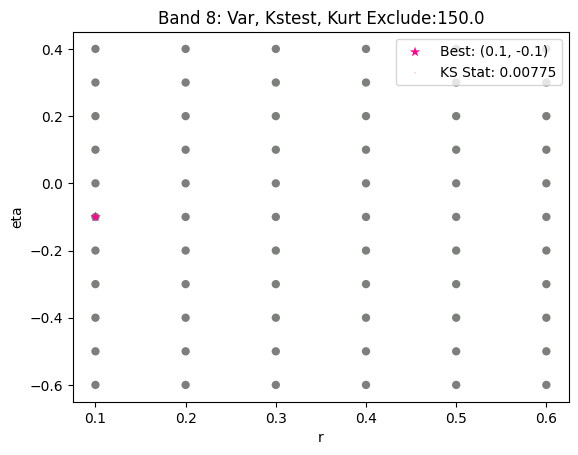

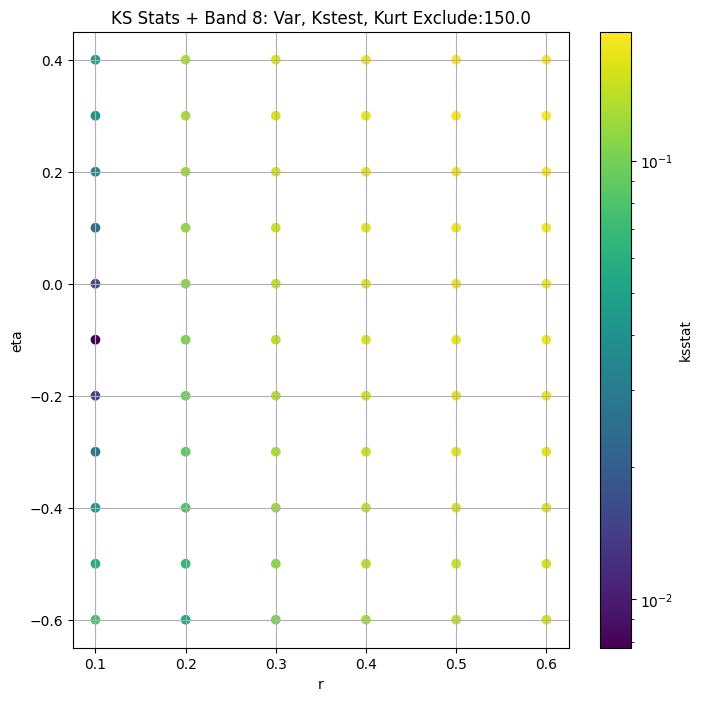

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.017096010141174456 0.36990875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.01780284803184684 0.3115406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.013664084961146794 0.28672865


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.01518136041979573 0.26770782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.015482400223719162 0.25202915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.010001205430733351 0.2268469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.012963360555815706 0.20693026


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.008401102040365038 0.1904916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.0093363625341788 0.17653881


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.00833776771196541 0.16446483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.010235467879124181 0.13599613
Number of samples: 100000, Without approximation : 100000.0


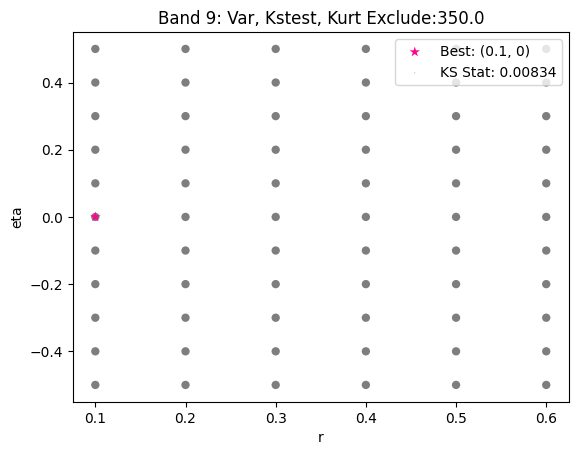

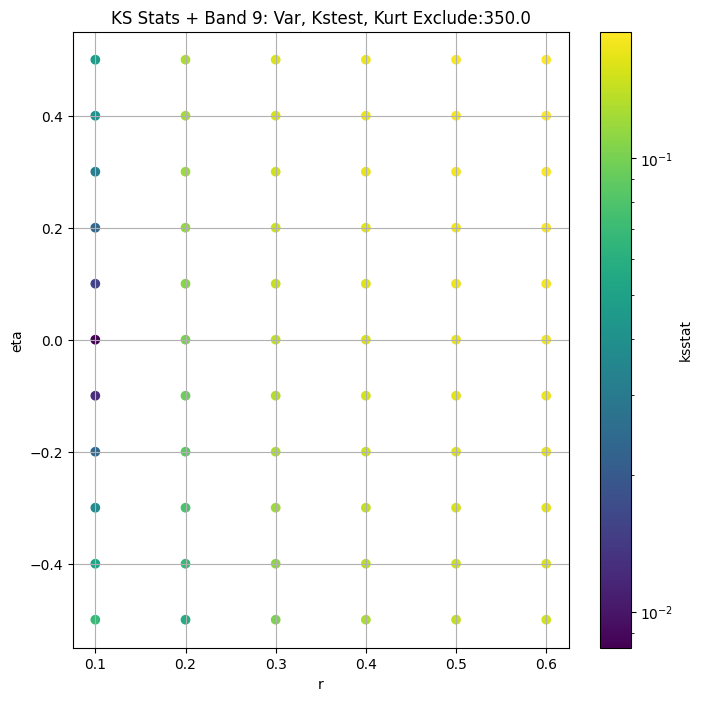

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     45.369470  37.192898  62.504337  105.943756   18.967024   423.49338   
3     28.487642  22.820335  40.596302  133.395070   25.079493   504.80347   
4     28.396730  23.002432  38.076363   95.742080   29.754055   357.59332   
5     17.751116  14.454866  22.739864   76.118126   32.262527   242.55627   
6     15.278565  12.067231  23.165314  177.711350   33.287712   678.38280   
7      6.052383   4.765122   8.304162  116.038055   37.999065   402.60687   
8      1.449654   1.027157   3.279829  950.878000   35.372276  2264.17430   
9      0.369909   0.285179   0.544106  163.989880   45.023357   583.67910   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.003831        0.4         -1.0   
3          100000.0             0.004601        0.5         -1.1   
4          100000.0             0.004490        0.2         -0.9   
5          100000.0             0.007473        0.1         -0.4   
6          100000.0             0.007807        0.1         -0.4   
7          100000.0             0.007551        0.1         -0.3   
8          100000.0             0.007753        0.1         -0.1   
9          100000.0             0.008338        0.1          0.0   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      7.622697e+00                    50.0           37.196613   
3      1.340125e+01                   150.0           19.297802   
4      8.767777e-03                    75.0           22.094799   
5      2.647671e-11                     0.0           17.751116   
6      1.821319e-11                    50.0           12.210901   
7      3.336594e-12                   100.0            4.270626   
8      2.050033e-13                   150.0            0.851089   
9      2.310871e-14                   350.0            0.164465   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
3                    0.004293  
4                    0.004293  
5                    0.004293  
6                    0.004293  
7                    0.004293  
8                    0.004293  
9                    0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 50.0 + 100 = 150, ksstat: 0.00338673076991065, var: 32.57291793823242


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 50.0 + 75 = 125, ksstat: 0.0029750967745256034, var: 33.469173431396484


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 50.0 + 50 = 100, ksstat: 0.002557508271949078, var: 34.49458312988281


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 50.0 + 25 = 75, ksstat: 0.002437952170275582, var: 35.703861236572266


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 50.0 + 0 = 50, ksstat: 0.0017829618967941663, var: 37.19661331176758


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 50.0 + -25 = 25, ksstat: 0.002218282233198643, var: 39.26308059692383


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 50.0 + -50 = 0, ksstat: 0.0030953925019796547, var: 45.369468688964844
Number of samples: 100000, Without approximation : 100000.0


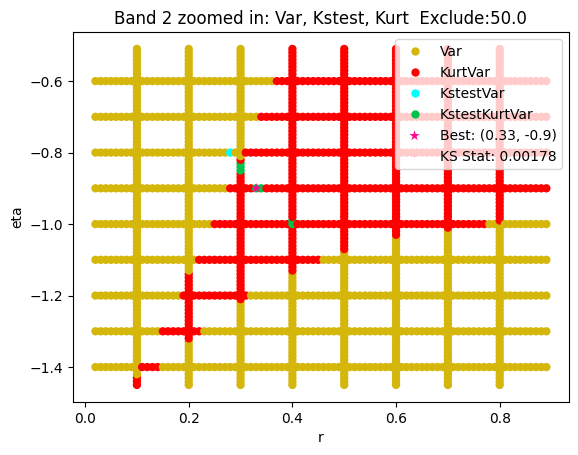

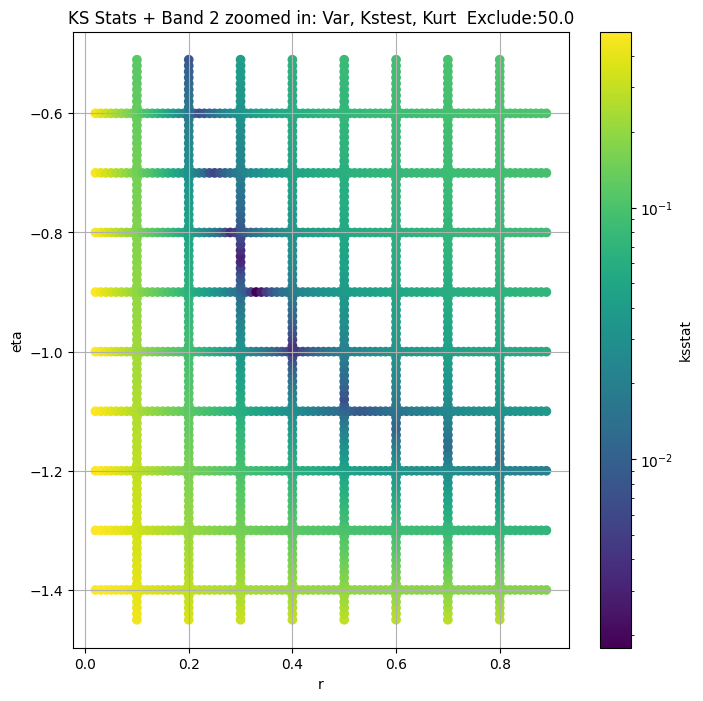

Band 3


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + 100 = 250, ksstat: 0.004202895457866189, var: 17.329727172851562


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + 75 = 225, ksstat: 0.003897562526392121, var: 17.755382537841797


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + 50 = 200, ksstat: 0.0038584281160877754, var: 18.219467163085938


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + 25 = 175, ksstat: 0.003404786491396434, var: 18.73020362854004


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + 0 = 150, ksstat: 0.0028925470457500917, var: 19.297801971435547


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + -25 = 125, ksstat: 0.002413181184760053, var: 19.93854331970215


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + -50 = 100, ksstat: 0.0020611275084861398, var: 20.677736282348633


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + -75 = 75, ksstat: 0.0015886475572948113, var: 21.558860778808594


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 150.0 + -100 = 50, ksstat: 0.0015299211901376175, var: 22.656187057495117
Number of samples: 100000, Without approximation : 100000.0


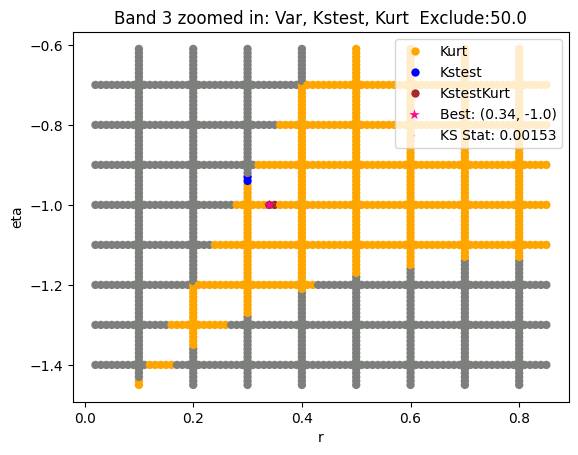

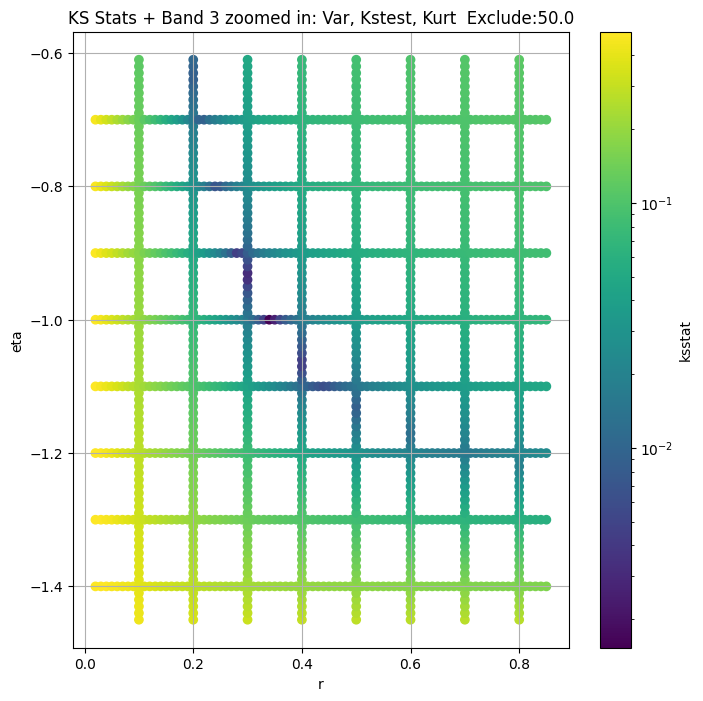

Band 4


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + 100 = 175, ksstat: 0.0056375005038065695, var: 18.849998474121094


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + 75 = 150, ksstat: 0.005475264683625056, var: 19.52247428894043


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + 50 = 125, ksstat: 0.004923082232236472, var: 20.270183563232422


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + 25 = 100, ksstat: 0.005063090839603653, var: 21.116188049316406


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + 0 = 75, ksstat: 0.004490089124483412, var: 22.094799041748047


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + -25 = 50, ksstat: 0.00393641088356397, var: 23.27252197265625


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + -50 = 25, ksstat: 0.003388473771718987, var: 24.80495834350586


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 75.0 + -75 = 0, ksstat: 0.002634566248667203, var: 28.396730422973633
Number of samples: 100000, Without approximation : 100000.0


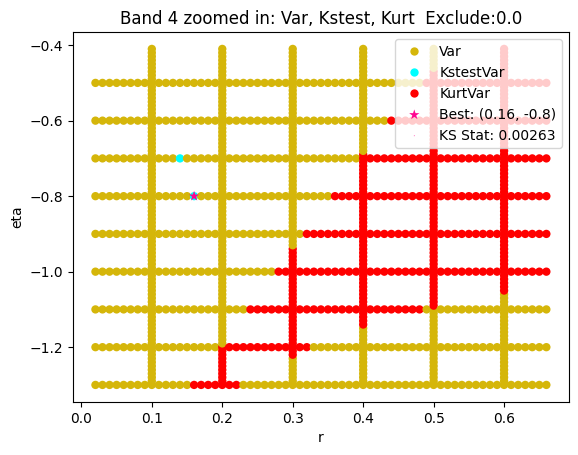

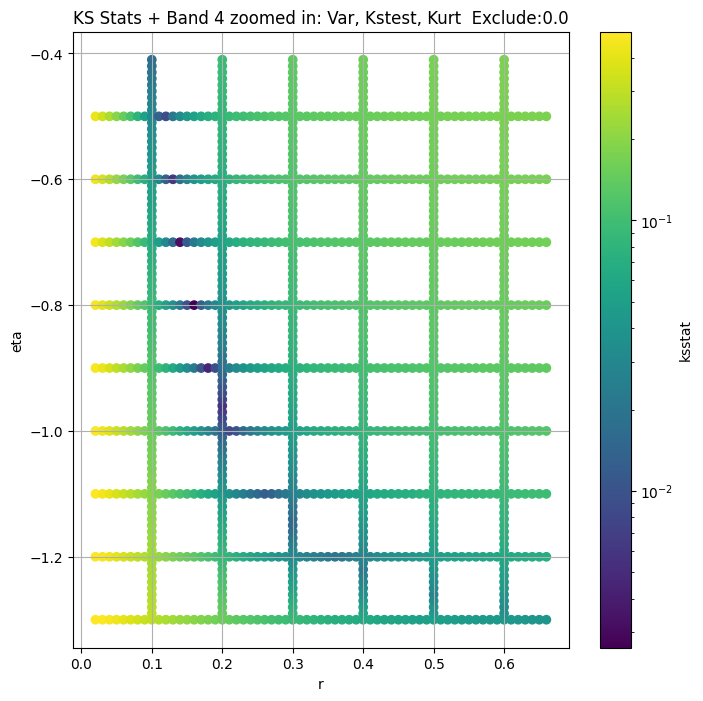

Band 5


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 0.0 + 100 = 100, ksstat: 0.007656374528005088, var: 13.20783805847168


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 0.0 + 75 = 75, ksstat: 0.007441305509173213, var: 13.845736503601074


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 0.0 + 50 = 50, ksstat: 0.007499912259160753, var: 14.613069534301758


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 0.0 + 25 = 25, ksstat: 0.006503455053174376, var: 15.613714218139648


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 0.0 + 0 = 0, ksstat: 0.005753717747921227, var: 17.751115798950195
Number of samples: 100000, Without approximation : 100000.0


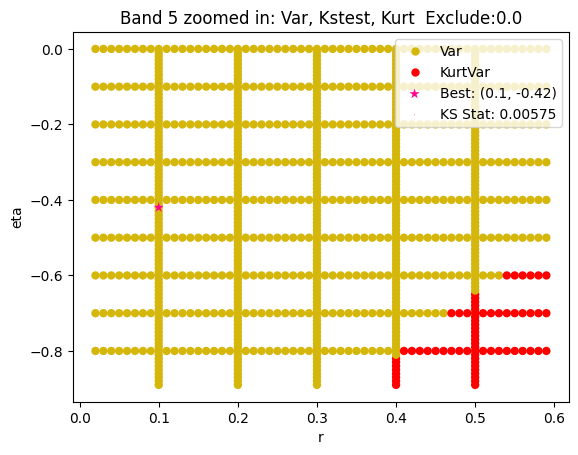

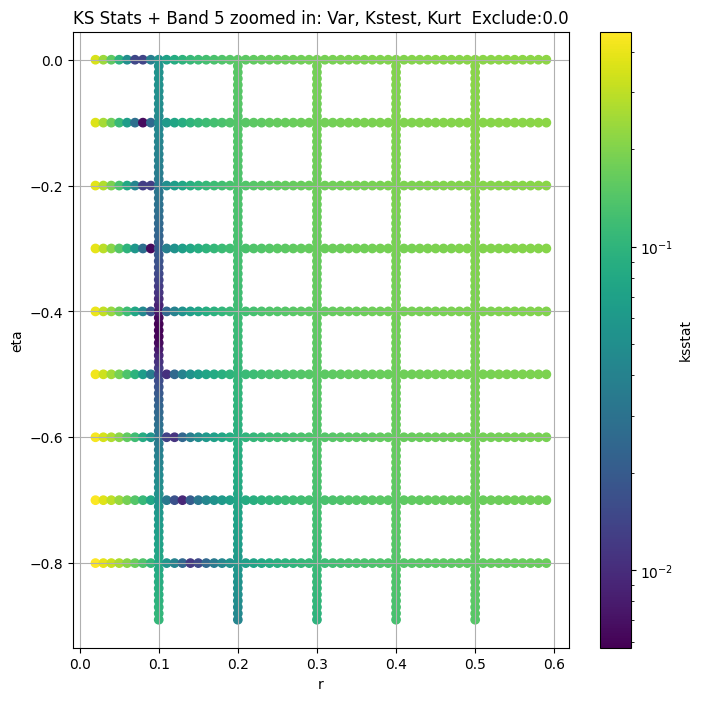

Band 6


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 6, 50.0 + 100 = 150, ksstat: 0.00834590222959919, var: 10.13808822631836


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 6, 50.0 + 75 = 125, ksstat: 0.008837444471288692, var: 10.55375862121582


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 6, 50.0 + 50 = 100, ksstat: 0.008412478223376065, var: 11.0219087600708


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 6, 50.0 + 25 = 75, ksstat: 0.008031878788755088, var: 11.563072204589844


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 6, 50.0 + 0 = 50, ksstat: 0.0075821588947569685, var: 12.210901260375977


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 6, 50.0 + -25 = 25, ksstat: 0.007362700533929067, var: 13.048805236816406


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 6, 50.0 + -50 = 0, ksstat: 0.009173120749272456, var: 15.278565406799316
Number of samples: 100000, Without approximation : 100000.0


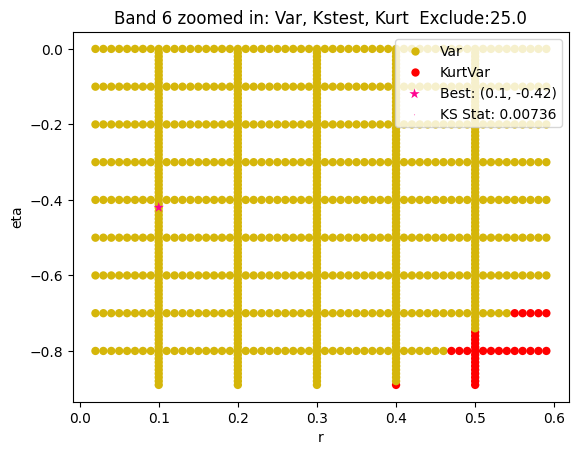

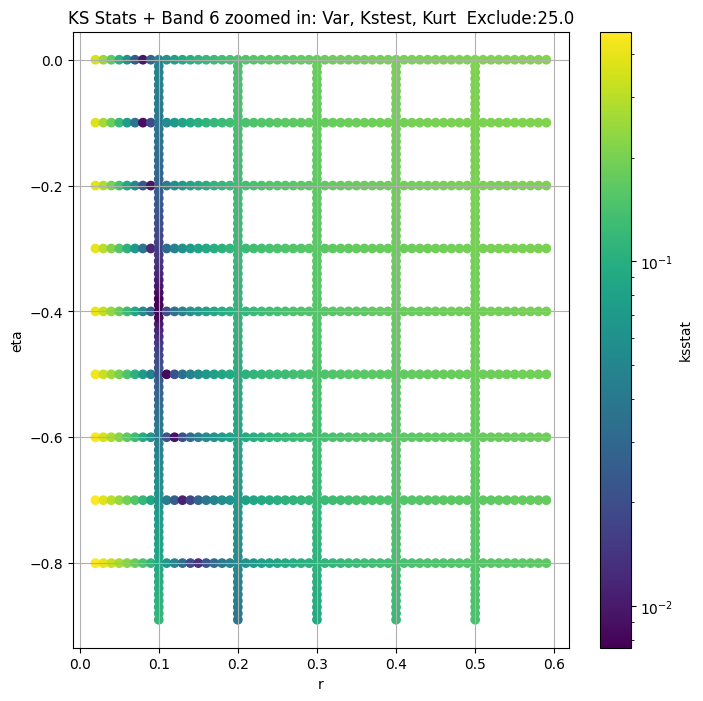

Band 7


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + 100 = 200, ksstat: 0.008159398021847841, var: 3.6015751361846924


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + 75 = 175, ksstat: 0.008507325752950882, var: 3.742234945297241


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + 50 = 150, ksstat: 0.007944154877765414, var: 3.897817850112915


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + 25 = 125, ksstat: 0.007667691187075873, var: 4.072001934051514


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + 0 = 100, ksstat: 0.007363409351091175, var: 4.270626544952393


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + -25 = 75, ksstat: 0.006986736116415617, var: 4.5024824142456055


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + -50 = 50, ksstat: 0.007005325406250228, var: 4.786360263824463


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + -75 = 25, ksstat: 0.008479283304261398, var: 5.164966583251953


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 7, 100.0 + -100 = 0, ksstat: 0.009119153273824065, var: 6.052382469177246
Number of samples: 100000, Without approximation : 100000.0


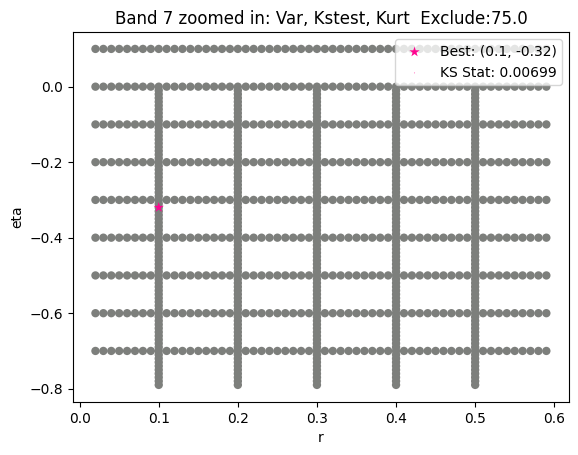

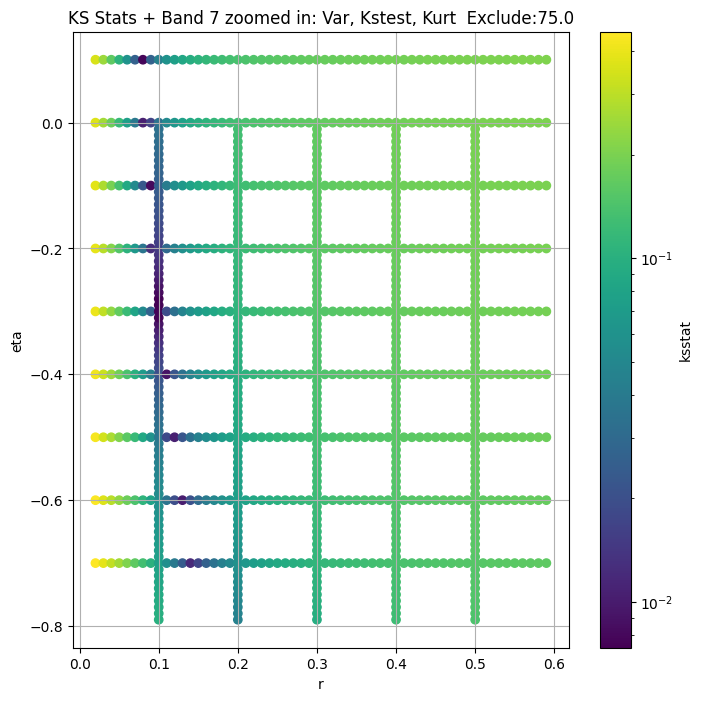

Band 8


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + 100 = 250, ksstat: 0.008164477932645964, var: 0.7377806901931763


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + 75 = 225, ksstat: 0.008420989032727168, var: 0.7625470757484436


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + 50 = 200, ksstat: 0.008151582521040639, var: 0.78938889503479


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + 25 = 175, ksstat: 0.007809904998068488, var: 0.8187398314476013


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + 0 = 150, ksstat: 0.007452776944286421, var: 0.8510888814926147


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + -25 = 125, ksstat: 0.0070779536165953005, var: 0.8871884346008301


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + -50 = 100, ksstat: 0.007524174937638961, var: 0.9282062649726868


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + -75 = 75, ksstat: 0.006834600078412301, var: 0.9760696291923523


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 150.0 + -100 = 50, ksstat: 0.009327826941169626, var: 1.0344042778015137
Number of samples: 100000, Without approximation : 100000.0


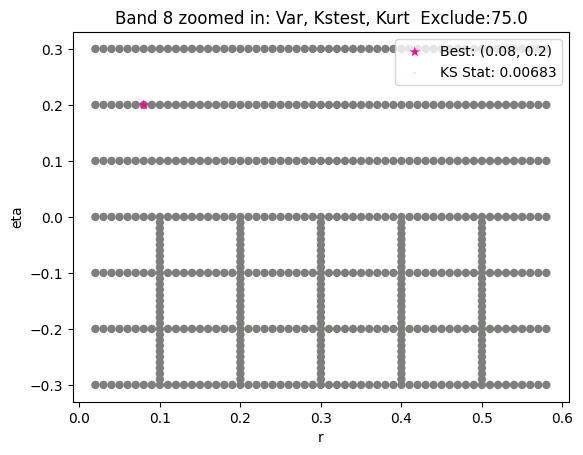

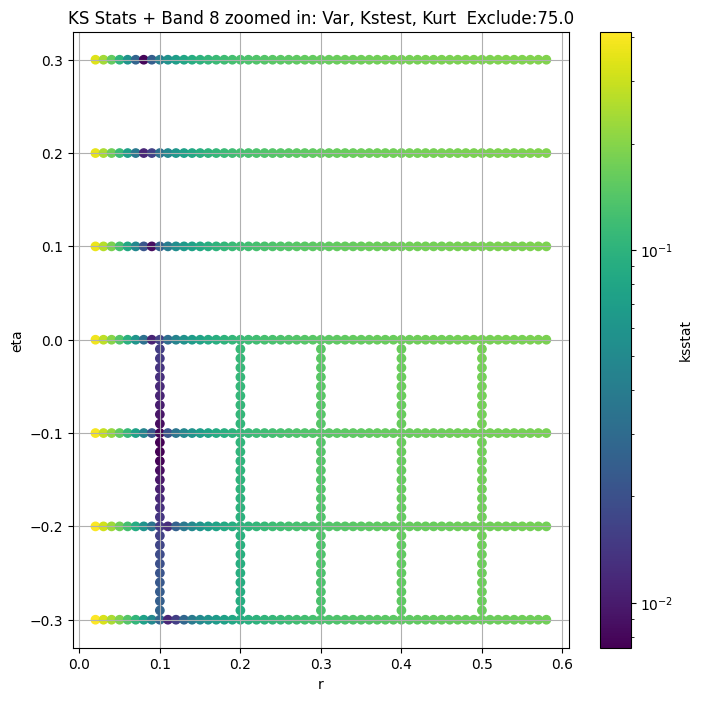

Band 9


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + 100 = 450, ksstat: 0.00923539806540943, var: 0.14443117380142212


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + 75 = 425, ksstat: 0.009117758872310549, var: 0.14900842308998108


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + 50 = 400, ksstat: 0.008920909817009104, var: 0.1538543552160263


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + 25 = 375, ksstat: 0.0083256343422778, var: 0.1589970737695694


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + 0 = 350, ksstat: 0.008116143937306596, var: 0.1644648313522339


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + -25 = 325, ksstat: 0.00796765889052723, var: 0.17029719054698944


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + -50 = 300, ksstat: 0.00776482449488939, var: 0.17653881013393402


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + -75 = 275, ksstat: 0.0074690731594947105, var: 0.18324625492095947


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 350.0 + -100 = 250, ksstat: 0.007438262689754954, var: 0.19049160182476044
Number of samples: 100000, Without approximation : 100000.0


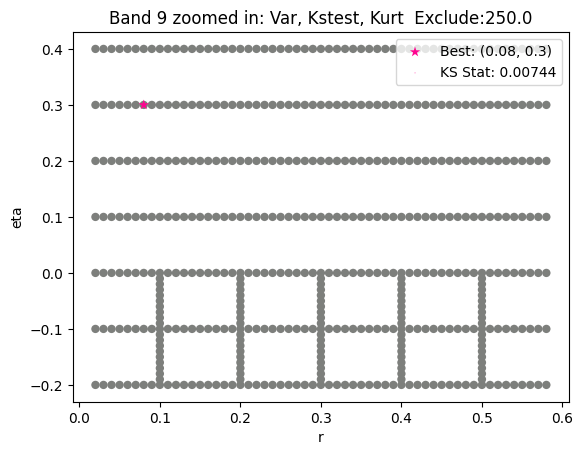

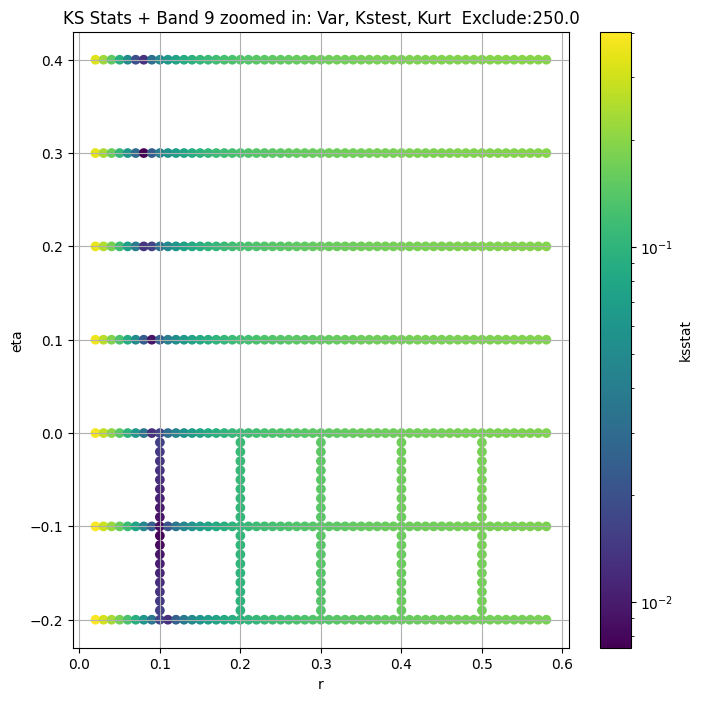

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     45.369470  37.192898  62.504337  105.943756   18.967024   423.49338   
3     28.487642  22.820335  40.596302  133.395070   25.079493   504.80347   
4     28.396730  23.002432  38.076363   95.742080   29.754055   357.59332   
5     17.751116  14.454866  22.739864   76.118126   32.262527   242.55627   
6     15.278565  12.067231  23.165314  177.711350   33.287712   678.38280   
7      6.052383   4.765122   8.304162  116.038055   37.999065   402.60687   
8      1.449654   1.027157   3.279829  950.878000   35.372276  2264.17430   
9      0.369909   0.285179   0.544106  163.989880   45.023357   583.67910   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.003831        0.4         -1.0   
3          100000.0             0.004601        0.5         -1.1   
4          100000.0             0.004490        0.2         -0.9   
5          100000.0             0.007473        0.1         -0.4   
6          100000.0             0.007807        0.1         -0.4   
7          100000.0             0.007551        0.1         -0.3   
8          100000.0             0.007753        0.1         -0.1   
9          100000.0             0.008338        0.1          0.0   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      7.622697e+00                    50.0           37.196613   
3      1.340125e+01                   150.0           22.656187   
4      8.767777e-03                    75.0           28.396730   
5      2.647671e-11                     0.0           17.751116   
6      1.821319e-11                    50.0           13.048805   
7      3.336594e-12                   100.0            4.502482   
8      2.050033e-13                   150.0            0.976070   
9      2.310871e-14                   350.0            0.190492   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.001783    0.33     -0.90   
3                    0.004293          0.001530    0.34     -1.00   
4                    0.004293          0.002635    0.16     -0.80   
5                    0.004293          0.005754    0.10     -0.42   
6                    0.004293          0.007363    0.10     -0.42   
7                    0.004293          0.006987    0.10     -0.32   
8                    0.004293          0.006835    0.08      0.20   
9                    0.004293          0.007438    0.08      0.30   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.818503e+00                 50.0       569530  
3     1.948034e+00                 50.0       759375  
4     1.839379e-04                  0.0       253125  
5     3.029422e-11                  0.0        56250  
6     2.226921e-11                 25.0        35593  
7     3.989758e-12                 75.0        37500  
8     1.400836e-18                 75.0        37500  
9     1.537443e-19                250.0        33783

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

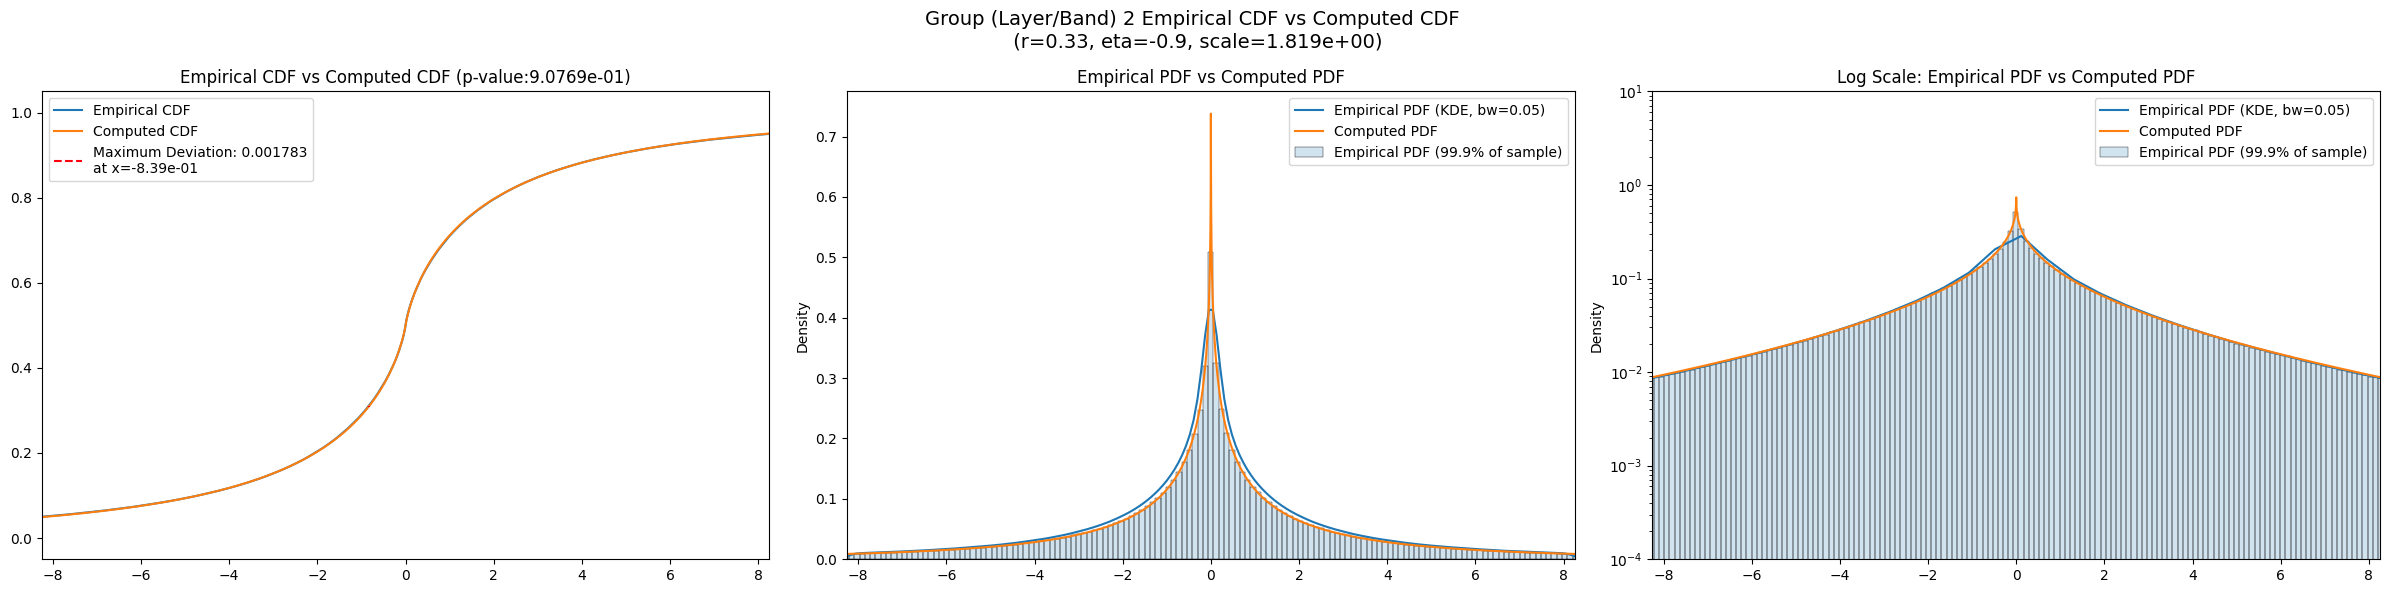

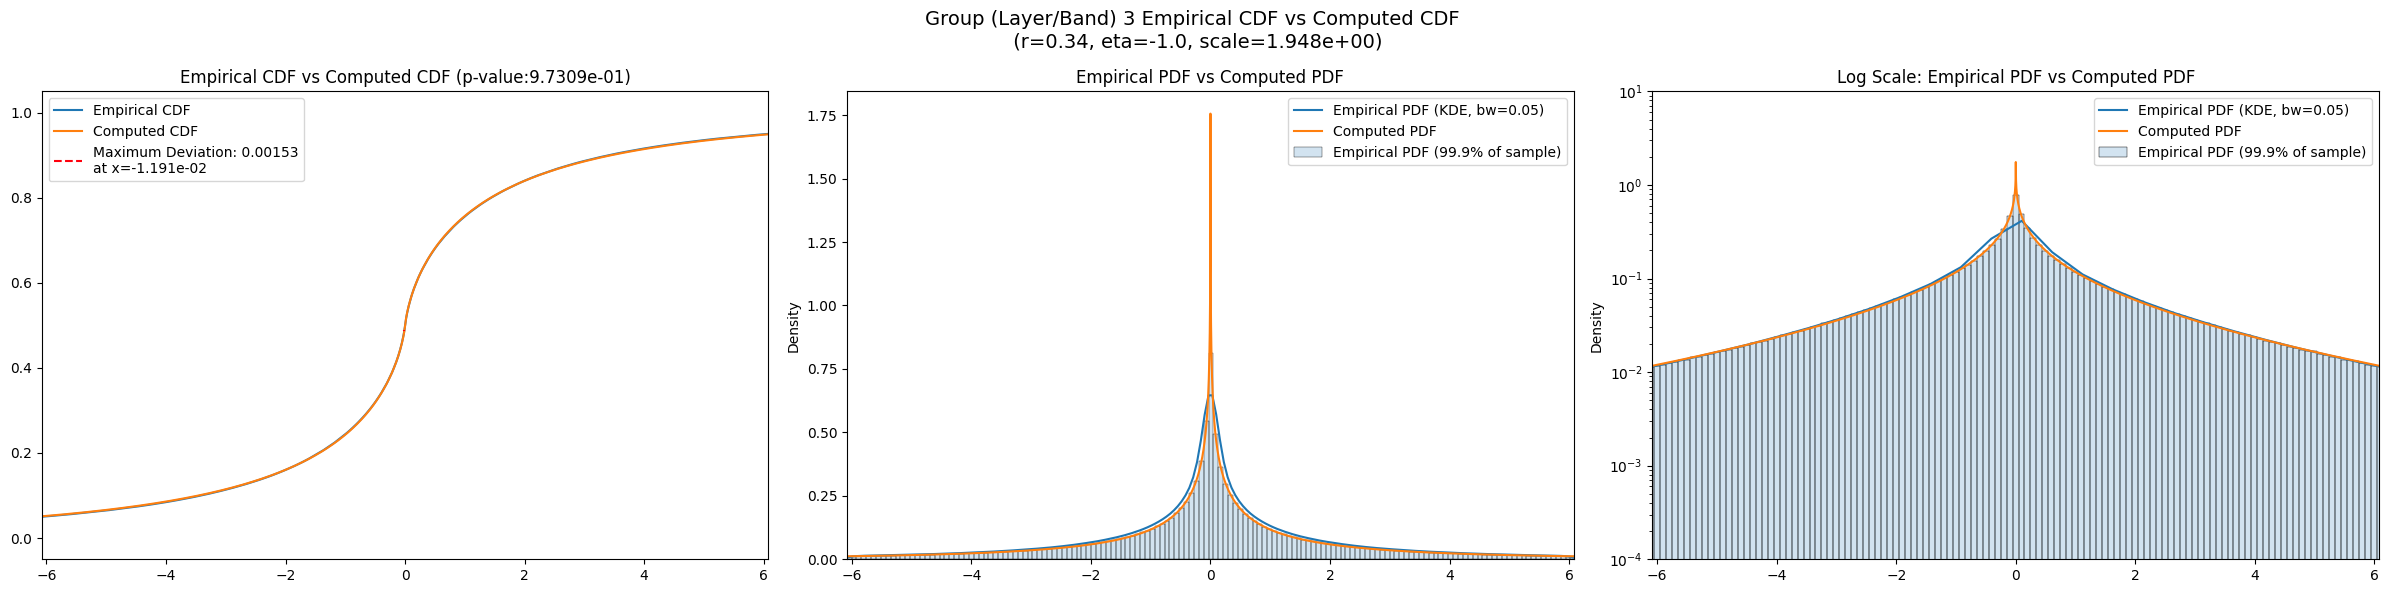

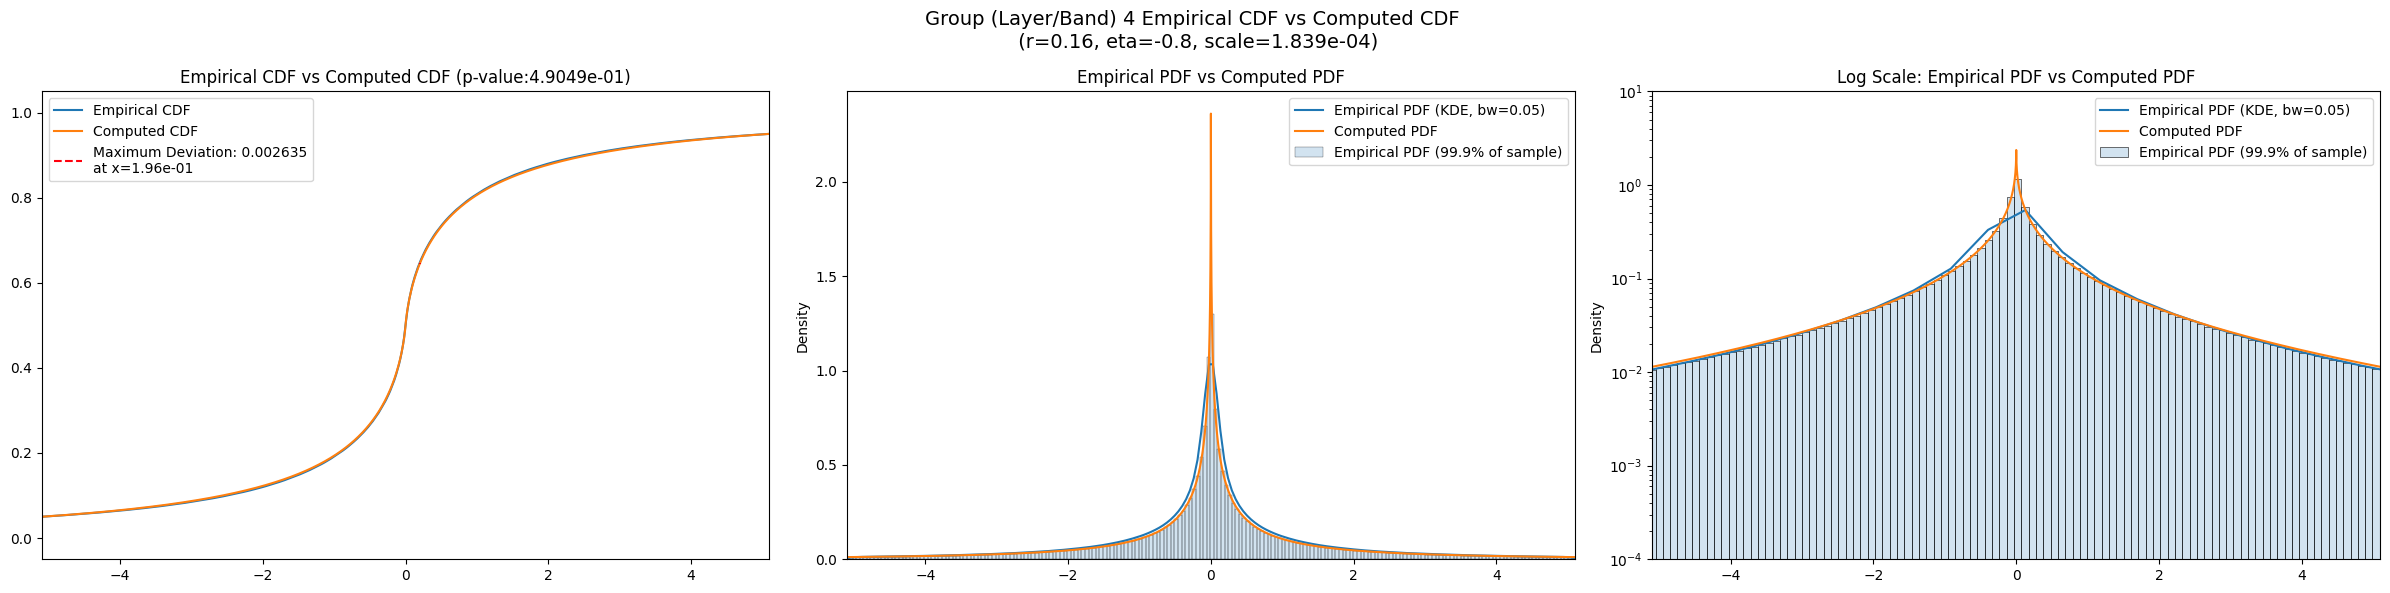

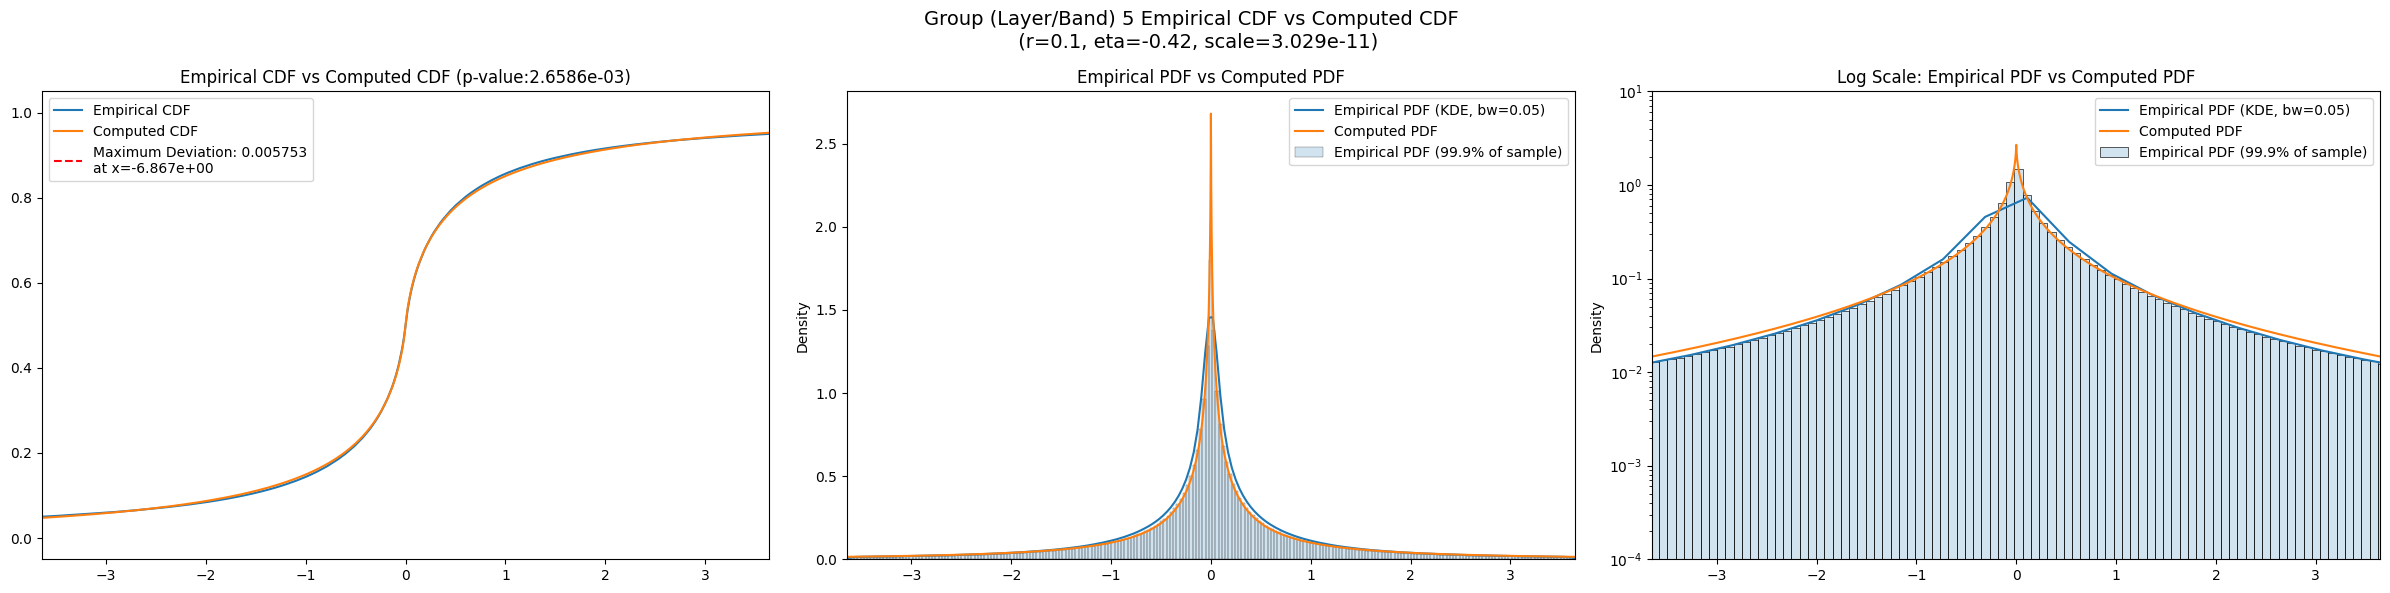

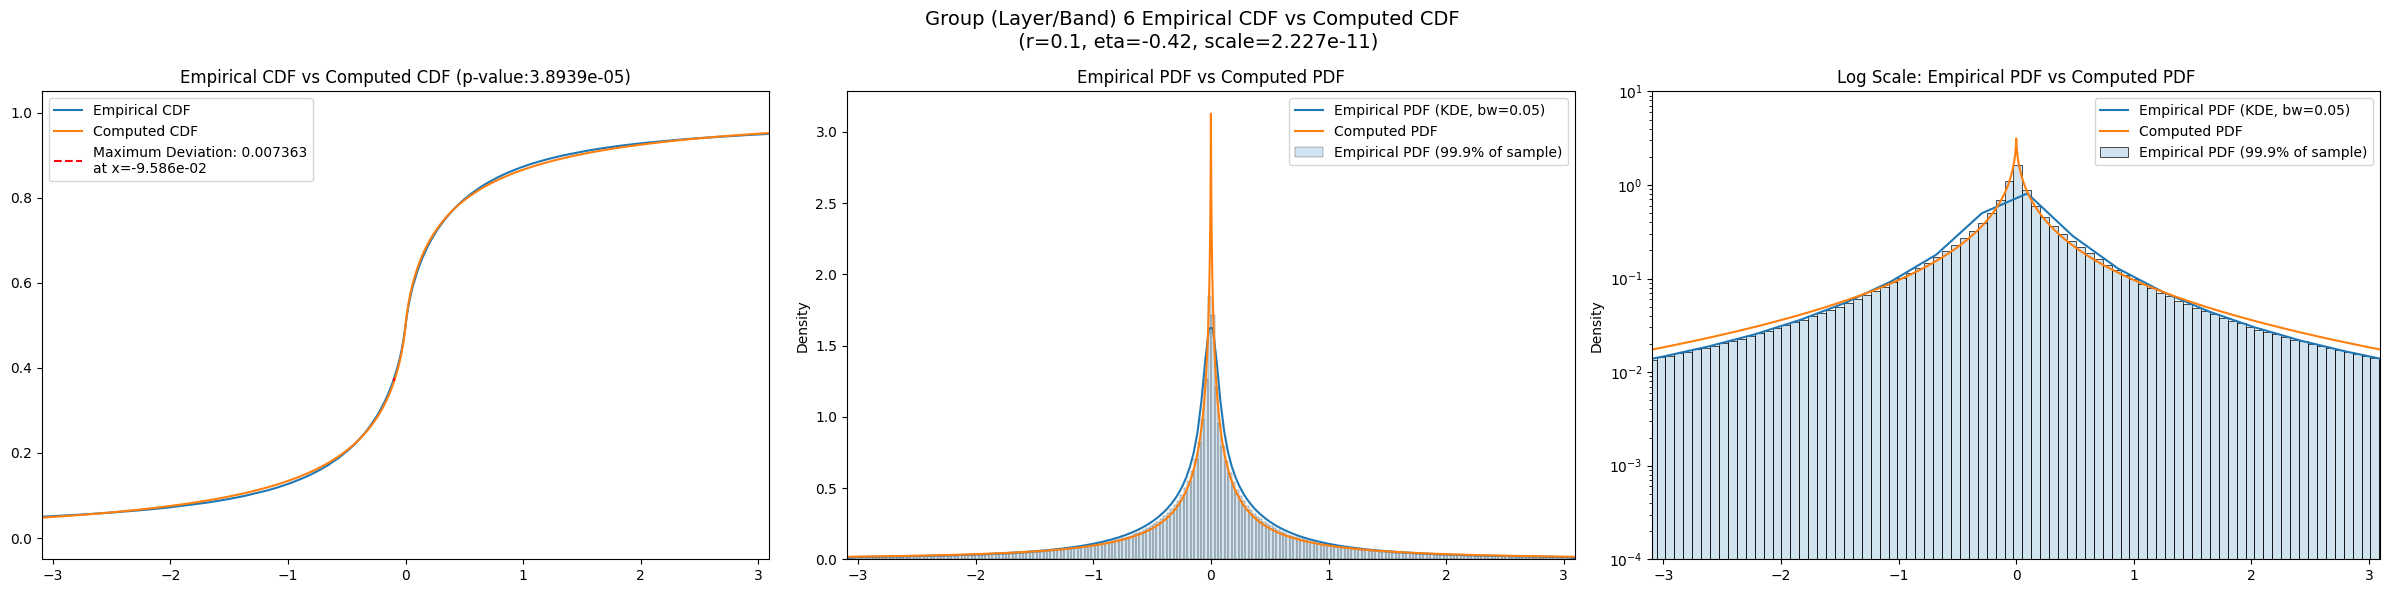

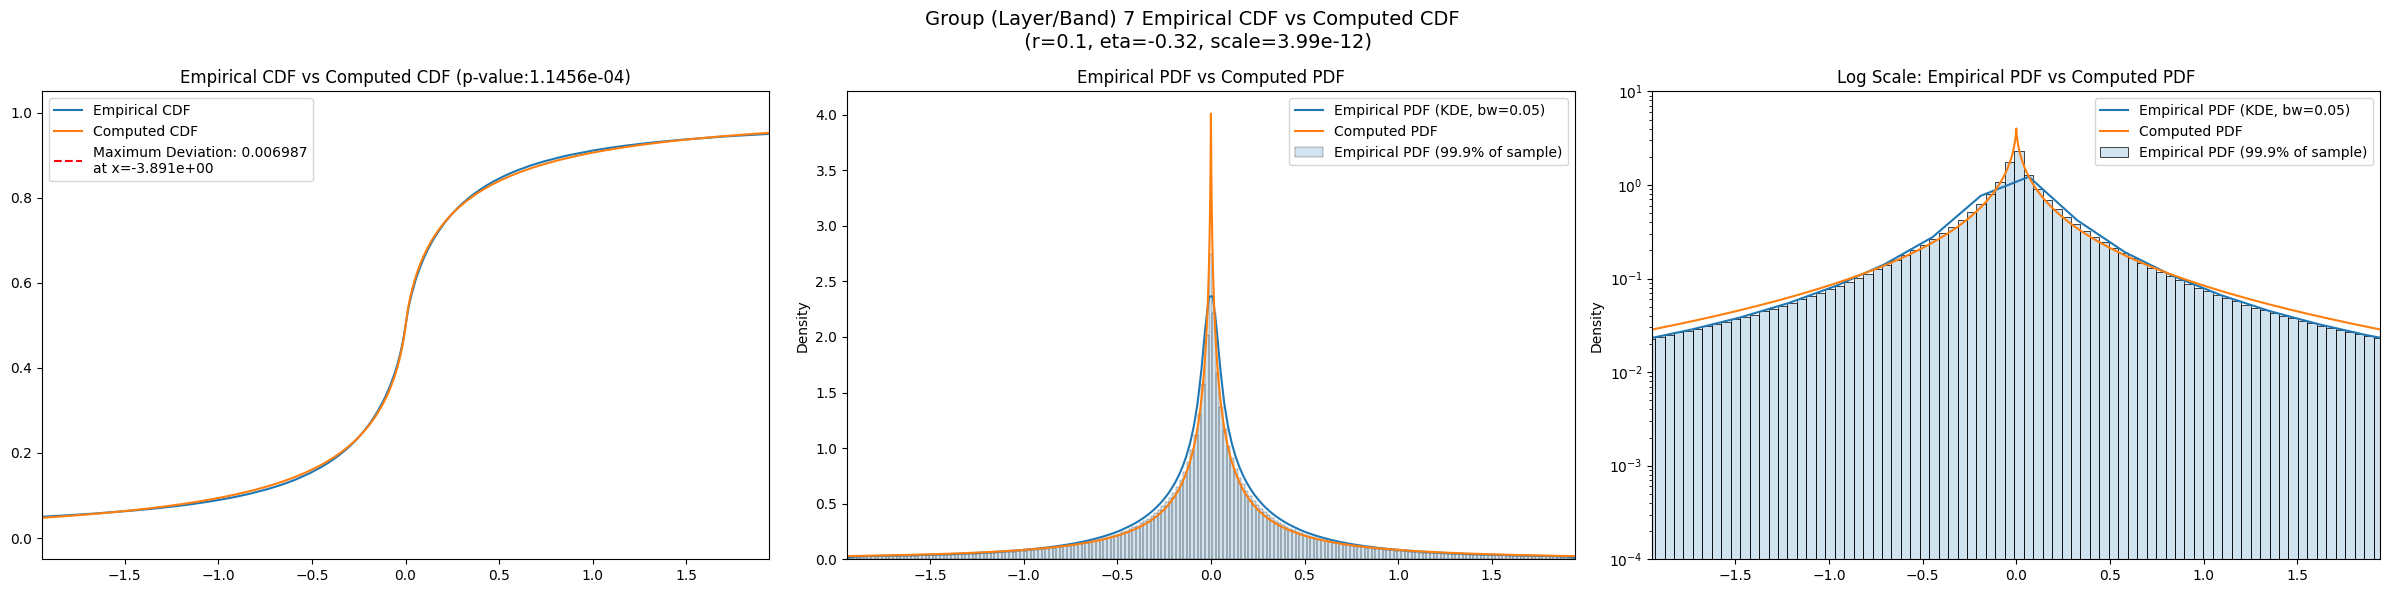

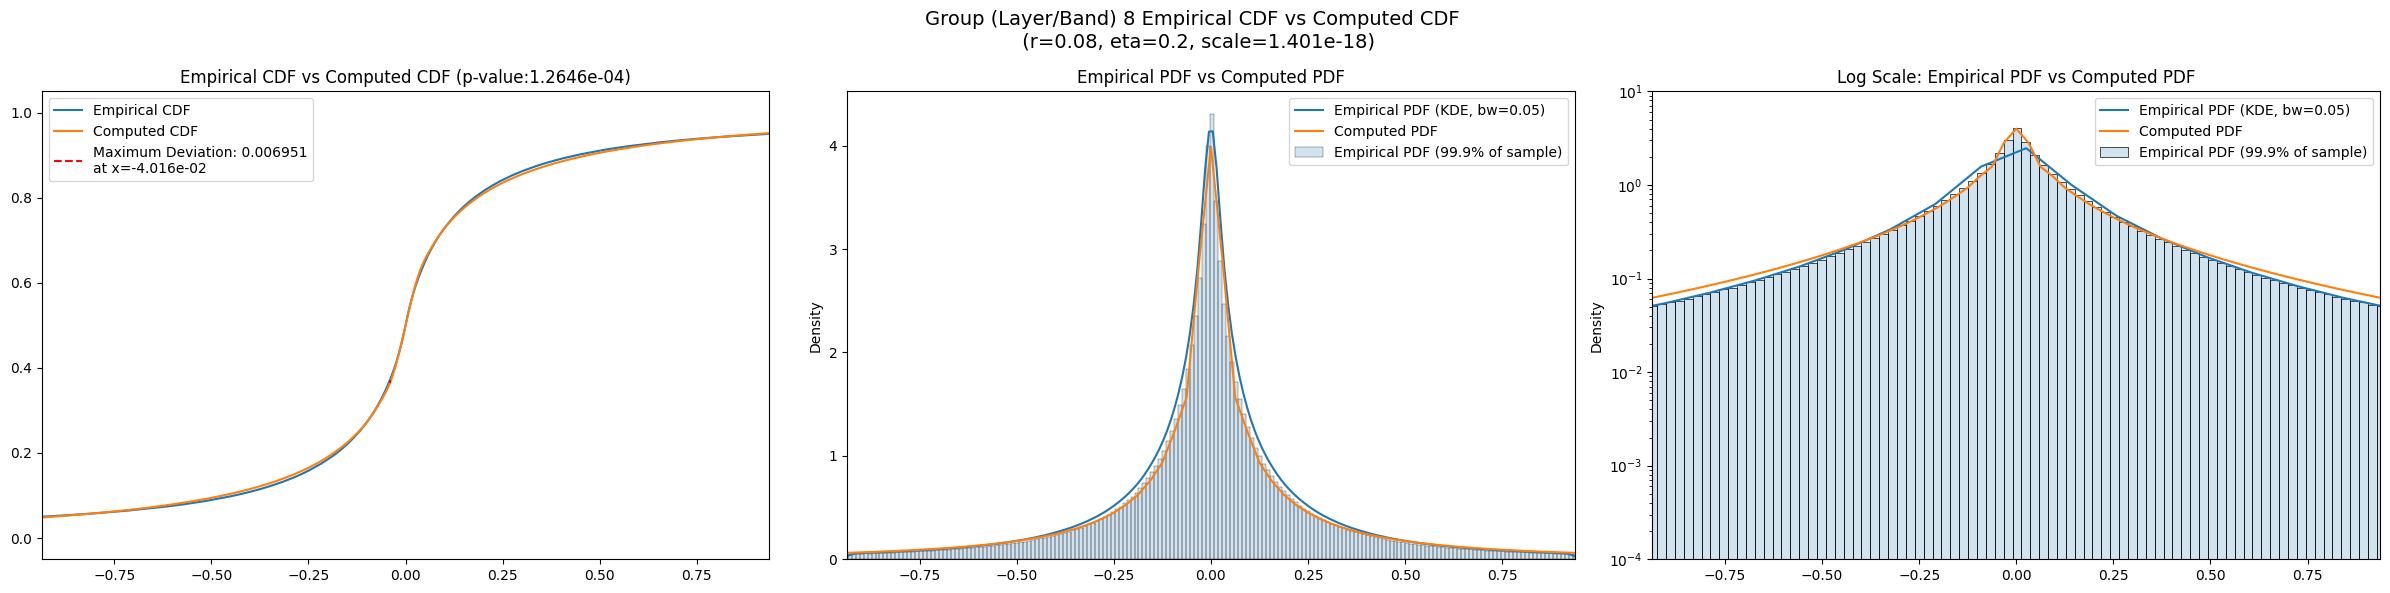

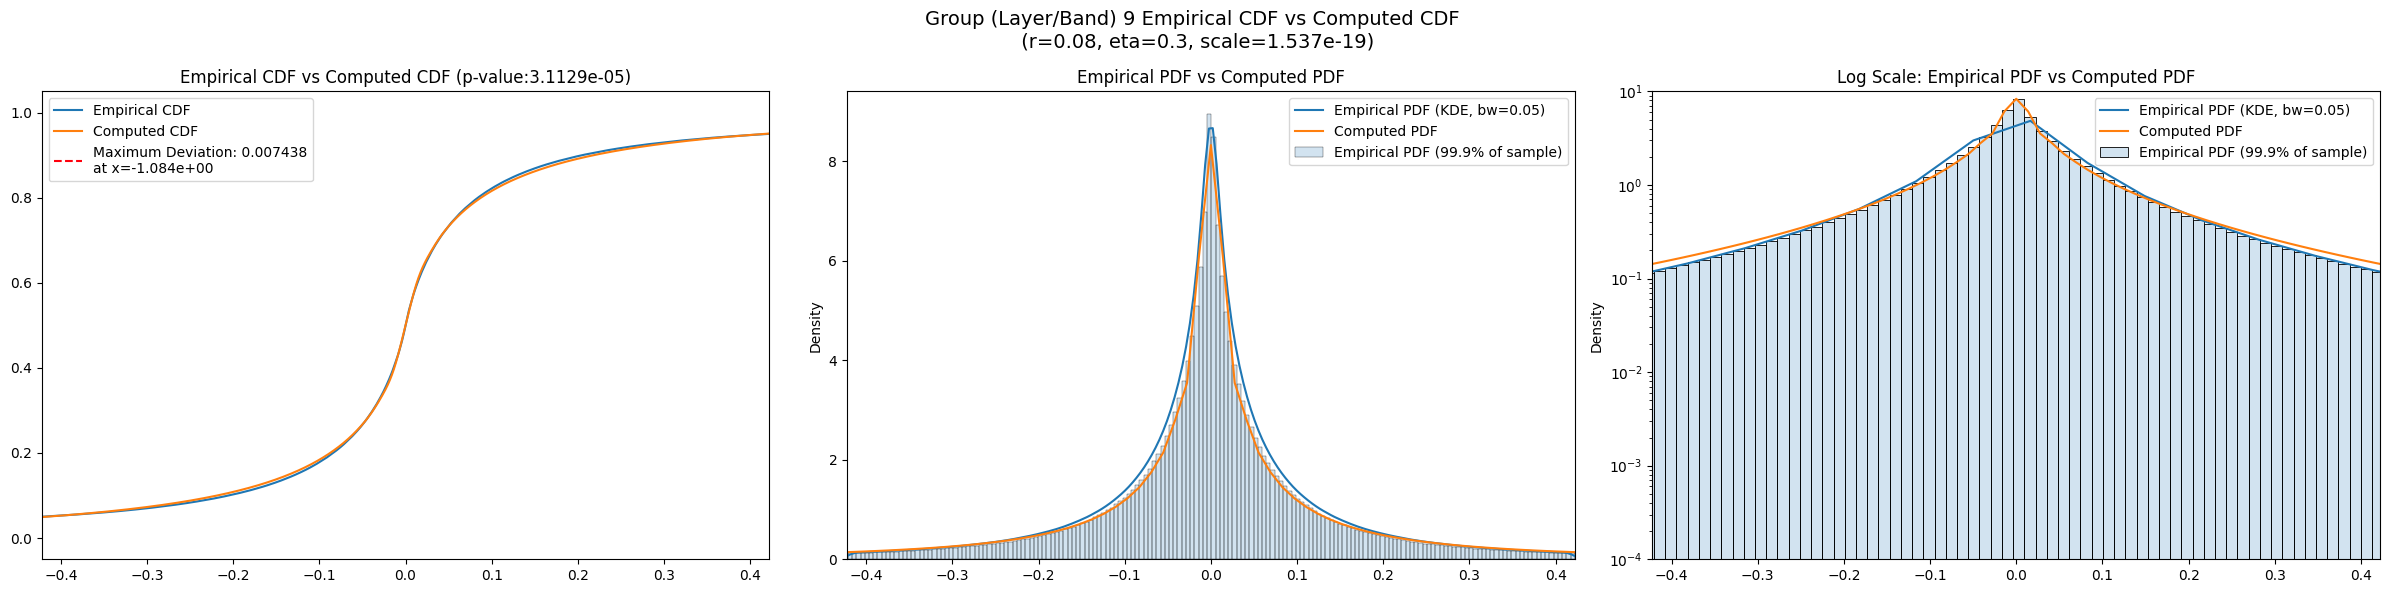

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     45.369470  37.192898  62.504337  105.943756   18.967024   423.49338   
3     28.487642  22.820335  40.596302  133.395070   25.079493   504.80347   
4     28.396730  23.002432  38.076363   95.742080   29.754055   357.59332   
5     17.751116  14.454866  22.739864   76.118126   32.262527   242.55627   
6     15.278565  12.067231  23.165314  177.711350   33.287712   678.38280   
7      6.052383   4.765122   8.304162  116.038055   37.999065   402.60687   
8      1.449654   1.027157   3.279829  950.878000   35.372276  2264.17430   
9      0.369909   0.285179   0.544106  163.989880   45.023357   583.67910   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2          100000.0             0.003831        0.4         -1.0  ...   
3          100000.0             0.004601        0.5         -1.1  ...   
4          100000.0             0.004490        0.2         -0.9  ...   
5          100000.0             0.007473        0.1         -0.4  ...   
6          100000.0             0.007807        0.1         -0.4  ...   
7          100000.0             0.007551        0.1         -0.3  ...   
8          100000.0             0.007753        0.1         -0.1  ...   
9          100000.0             0.008338        0.1          0.0  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           2.637960              0.066024                   0.0   
3           1.808100              0.071984                   0.0   
4           1.179220              0.083283                   0.0   
5           0.785103              0.081542                   0.0   
6           0.688741              0.077545                   0.0   
7           0.457185              0.075282                   0.0   
8           0.240871              0.071320                   0.0   
9           0.114116              0.069496                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          2.284530             0.040236        4.182970e-141  1.779330   
3          1.552120             0.046864        2.694830e-191  1.209020   
4          1.020630             0.058908        4.356860e-302  0.778780   
5          0.692087             0.057413        5.822060e-287  0.522623   
6          0.610709             0.053747        1.622010e-251  0.458710   
7          0.406647             0.051242        1.214290e-228  0.306375   
8          0.215072             0.046875        2.183970e-191  0.163278   
9          0.101657             0.044709        3.871840e-174  0.077479   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.041471  7.113290e-150              0.907689  
3          0.048452  1.874970e-204              0.973093  
4          0.058605  5.378060e-299              0.490487  
5          0.055362  7.618020e-267              0.002654  
6          0.051206  2.567480e-228              0.000039  
7          0.048500  7.399280e-205              0.000115  
8          0.043689  2.699710e-166              0.000174  
9          0.041861  1.051610e-152              0.000031  

[8 rows x 30 columns]

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003831                 0.004293          0.001783   
3                0.004601                 0.004293          0.001530   
4                0.004490                 0.004293          0.002635   
5                0.007473                 0.004293          0.005754   
6                0.007807                 0.004293          0.007363   
7                0.007551                 0.004293          0.006987   
8                0.007753                 0.004293          0.006835   
9                0.008338                 0.004293          0.007438   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.066024             0.040236       0.041471  
3                 0.071984             0.046864       0.048452  
4                 0.083283             0.058908       0.058605  
5                 0.081542             0.057413       0.055362  
6                 0.077545             0.053747       0.051206  
7                 0.075282             0.051242       0.048500  
8                 0.071320             0.046875       0.043689  
9                 0.069496             0.044709       0.041861

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2              37.196613          0.001783    0.33     -0.90  1.818503e+00   
3              22.656187          0.001530    0.34     -1.00  1.948034e+00   
4              28.396730          0.002635    0.16     -0.80  1.839379e-04   
5              17.751116          0.005754    0.10     -0.42  3.029422e-11   
6              13.048805          0.007363    0.10     -0.42  2.226921e-11   
7               4.502482          0.006987    0.10     -0.32  3.989758e-12   
8               0.976070          0.006835    0.08      0.20  1.400836e-18   
9               0.190492          0.007438    0.08      0.30  1.537443e-19   

      best_exclude_cutoff  
band                       
2                    50.0  
3                    50.0  
4                     0.0  
5                     0.0  
6                    25.0  
7                    75.0  
8                    75.0  
9                   250.0